In [1]:
import os
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas_datareader as web
from dateutil.relativedelta import relativedelta
from ticker_download_predict_upload import DownloadPredictUpload

In [2]:
dpu = DownloadPredictUpload()

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### Set the tickers in the portfolio

In [3]:
tickers = ["I:SPX", "QQQ", "VXUS", "GLD"]
D = len(tickers)

### Get the past year of ticker close prices

In [4]:
long_df_filename = os.path.join("input", f"Year of Tickers {dpu.get_today_date()}.csv")
if os.path.exists(long_df_filename):
    long_df = pd.read_csv(long_df_filename)
    long_df["datetime"] = pd.to_datetime(long_df["datetime"])
    long_df["datetime"] = long_df["datetime"].apply(
        lambda x: pd.Timestamp(x).replace(hour=23, minute=59, second=59)
    )
    long_df.set_index("datetime", inplace=True)
    long_df.sort_index(inplace=True)
else:
    date_from = dpu.past_business_day(pd.Timestamp(dpu.get_today_date()), 253)
    date_to = dpu.past_business_day(pd.Timestamp(dpu.get_today_date()), 1).replace(
        hour=23, minute=59, second=59
    )
    print(date_from, date_to)
    long_df = dpu.get_tickers(tickers, date_from=date_from, date_to=date_to)
    long_df.to_csv(long_df_filename, index=True)
long_df

2024-03-26 00:00:00 2025-03-28 23:59:59
I:SPX. Acquired 254 so far. Sleeping 5 seconds...
QQQ. Acquired 508 so far. Sleeping 5 seconds...
VXUS. Acquired 762 so far. Sleeping 5 seconds...
GLD. Acquired 1016 so far. Sleeping 5 seconds...


,ticker,open,high,low,close,volume,vwap,transactions
datetime,,,,,,,,
2024-03-25 04:00:00,VXUS,59.92,60.145,59.890,59.99,2756590.0,60.0644,16491.0
2024-03-25 04:00:00,QQQ,443.55,446.260,442.540,444.76,27779904.0,445.0143,304143.0
2024-03-25 04:00:00,GLD,201.19,201.950,200.965,200.99,4034750.0,201.3506,43483.0
2024-03-25 05:00:00,I:SPX,5219.52,5229.090,5216.090,5218.19,NaN,NaN,NaN
2024-03-26 04:00:00,GLD,202.65,202.760,201.070,201.64,5752677.0,201.8118,65878.0
...,...,...,...,...,...,...,...,...
2025-03-27 05:00:00,I:SPX,5695.64,5732.280,5670.940,5693.31,NaN,NaN,NaN
2025-03-28 04:00:00,QQQ,479.81,480.520,468.050,468.94,46220997.0,472.5443,501464.0
2025-03-28 04:00:00,VXUS,62.96,62.960,62.385,62.51,4341931.0,62.5748,28383.0


### Pivot the close prices for better analysis

In [5]:
wide_df = dpu.pivot_ticker_close_wide(long_df)
wide_df

ticker,GLD,I:SPX,QQQ,VXUS
2024-03-25 17:00:00,200.99,NaN,444.76,59.99
2024-03-25 17:00:00,NaN,5218.19,NaN,NaN
2024-03-26 17:00:00,201.64,NaN,443.32,59.99
2024-03-26 17:00:00,NaN,5203.58,NaN,NaN
2024-03-27 17:00:00,203.10,NaN,444.83,60.32
...,...,...,...,...
2025-03-26 17:00:00,NaN,5712.20,NaN,NaN
2025-03-27 17:00:00,281.97,NaN,481.62,63.25
2025-03-27 17:00:00,NaN,5693.31,NaN,NaN
2025-03-28 17:00:00,284.06,NaN,468.94,62.51


### Are there any missing values?

In [6]:
wide_df.isna().sum().sum()

np.int64(1016)

### Calculate % change and covert to a percentage

In [7]:
returns_df = wide_df.pct_change()
returns_df = returns_df.iloc[1:] * 100
returns_df

/var/folders/_f/zmxbx_t93v96nklchvbj6j2r0000gn/T/ipykernel_5556/1169589287.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = wide_df.pct_change()


ticker,GLD,I:SPX,QQQ,VXUS
2024-03-25 17:00:00,0.000000,NaN,0.000000,0.000000
2024-03-26 17:00:00,0.323399,0.000000,-0.323770,0.000000
2024-03-26 17:00:00,0.000000,-0.279982,0.000000,0.000000
2024-03-27 17:00:00,0.724063,0.000000,0.340612,0.550092
2024-03-27 17:00:00,0.000000,0.863060,0.000000,0.000000
...,...,...,...,...
2025-03-26 17:00:00,0.000000,-1.115699,0.000000,0.000000
2025-03-27 17:00:00,1.340569,0.000000,-0.569801,0.221835
2025-03-27 17:00:00,0.000000,-0.330696,0.000000,0.000000
2025-03-28 17:00:00,0.741214,0.000000,-2.632781,-1.169960


### Calculate mean returns

In [8]:
mean_returns = returns_df.mean()
mean_returns

ticker
GLD      0.070641
I:SPX    0.015213
QQQ      0.014234
VXUS     0.009912
dtype: float64

### Calculate covariance matrix

In [9]:
cov = returns_df.cov()
cov_np = cov.to_numpy()
cov_np

array([[ 4.77481689e-01, -1.07888982e-03,  1.26498848e-01,
         1.71072762e-01],
       [-1.07888982e-03,  3.85703180e-01, -2.17396045e-04,
        -1.51391052e-04],
       [ 1.26498848e-01, -2.17396045e-04,  7.56616986e-01,
         3.30492276e-01],
       [ 1.71072762e-01, -1.51391052e-04,  3.30492276e-01,
         3.59623037e-01]])

### Simulate 10,000 portfolios by generating random weights

In [10]:
n_portfolios = 10_000
d = len(mean_returns)
simulated_returns = np.zeros(n_portfolios)
simulated_risks = np.zeros(n_portfolios)
random_weights = []
rand_range = 1.0

for i in range(n_portfolios):
    w = np.random.random(d) * rand_range - rand_range / 2  # Allows short-selling
    w[-1] = 1 - w[:-1].sum()
    np.random.shuffle(w)
    random_weights.append(w)
    simulated_return = mean_returns.dot(w)
    simulated_risk = np.sqrt(w.dot(cov_np).dot(w))
    simulated_returns[i] = simulated_return
    simulated_risks[i] = simulated_risk

### Calculate minimum variance portfolio

In [11]:
weight_bounds = [(-0.5, None)] * D

In [12]:
def get_portfolio_variance(weights):
    return weights.dot(cov_np).dot(weights)

In [13]:
def portfolio_weights_constraint(weights):
    return weights.sum() - 1

In [14]:
min_var_result = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
min_var_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.16367879868680635
       x: [ 2.207e-01  4.249e-01  4.486e-02  3.095e-01]
     nit: 6
     jac: [ 3.271e-01  3.272e-01  3.281e-01  3.277e-01]
    nfev: 30
    njev: 6

In [15]:
min_var_risk = np.sqrt(min_var_result.fun)
min_var_weights = min_var_result.x
min_var_return = min_var_weights.dot(mean_returns)
min_var_risk, min_var_weights, min_var_return

(np.float64(0.4045723652040588),
 array([0.22073056, 0.42487185, 0.04486454, 0.30953306]),
 np.float64(0.025762882948987032))

### Calculate efficient frontier

In [16]:
num_portfolios = 100
target_returns = np.linspace(min_var_return, simulated_returns.max(), num_portfolios)
target_returns

array([0.02576288, 0.02704422, 0.02832556, 0.02960689, 0.03088823,
       0.03216957, 0.03345091, 0.03473224, 0.03601358, 0.03729492,
       0.03857626, 0.03985759, 0.04113893, 0.04242027, 0.0437016 ,
       0.04498294, 0.04626428, 0.04754562, 0.04882695, 0.05010829,
       0.05138963, 0.05267096, 0.0539523 , 0.05523364, 0.05651498,
       0.05779631, 0.05907765, 0.06035899, 0.06164033, 0.06292166,
       0.064203  , 0.06548434, 0.06676567, 0.06804701, 0.06932835,
       0.07060969, 0.07189102, 0.07317236, 0.0744537 , 0.07573504,
       0.07701637, 0.07829771, 0.07957905, 0.08086038, 0.08214172,
       0.08342306, 0.0847044 , 0.08598573, 0.08726707, 0.08854841,
       0.08982974, 0.09111108, 0.09239242, 0.09367376, 0.09495509,
       0.09623643, 0.09751777, 0.09879911, 0.10008044, 0.10136178,
       0.10264312, 0.10392445, 0.10520579, 0.10648713, 0.10776847,
       0.1090498 , 0.11033114, 0.11161248, 0.11289381, 0.11417515,
       0.11545649, 0.11673783, 0.11801916, 0.1193005 , 0.12058

In [17]:
def target_returns_constraint(weights, target_return):
    return weights.dot(mean_returns) - target_return

In [18]:
constraints = [
    {"type": "eq", "fun": target_returns_constraint, "args": [target_returns[0]]},
    {"type": "eq", "fun": portfolio_weights_constraint},
]

In [19]:
optimized_risks = []
for target_return in target_returns:
    constraints[0]["args"] = [target_return]
    result = minimize(
        fun=get_portfolio_variance,
        x0=np.ones(D) / D,
        method="SLSQP",
        bounds=weight_bounds,
        constraints=constraints,
    )
    if result.status == 0:
        optimized_risks.append(np.sqrt(result.fun))
    else:
        print("Optimization error!", result)

### Calculate Sharpe Ratio

In [20]:
today_date = dpu.get_today_date()
risk_free_rate_filename = os.path.join("input", f"Risk Free Rate {today_date}.json")
if os.path.exists(risk_free_rate_filename):
    print("Reading risk-free rate cache...")
    with open(risk_free_rate_filename, "r", encoding="utf-8") as f:
        risk_free_rate_data = json.load(f)
        print(risk_free_rate_data)
        daily_risk_free_rate = risk_free_rate_data["daily_risk_free_rate"]
else:
    end_date = datetime.datetime.now()
    start_date = end_date - relativedelta(years=1)
    print(start_date, end_date)
    tb3m_df = web.DataReader("DTB3", "fred", start_date, end_date).sort_values(
        "DATE", ascending=False
    )
    risk_free_rate = float(tb3m_df.iloc[0]["DTB3"])
    daily_risk_free_rate = risk_free_rate / 252
    risk_free_rate_date = str(tb3m_df.index[0])
    print(daily_risk_free_rate)
    risk_free_rate_data = {
        "risk_free_rate": risk_free_rate,
        "daily_risk_free_rate": daily_risk_free_rate,
        "risk_free_rate_date": risk_free_rate_date,
    }
    with open(risk_free_rate_filename, "w", encoding="utf-8") as f:
        json.dump(risk_free_rate_data, f, indent=4)

2024-03-31 07:45:44.008516 2025-03-31 07:45:44.008516
0.016666666666666666


In [21]:
def negative_sharpe_ratio(weights):
    mean = weights.dot(mean_returns)
    risk = np.sqrt(weights.dot(cov_np).dot(weights))
    return -(mean - daily_risk_free_rate) / risk

In [22]:
sharpe_ratio_result = minimize(
    fun=negative_sharpe_ratio,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
sharpe_ratio_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.08867481671036058
       x: [ 1.411e+00  8.174e-02  7.707e-03 -5.000e-01]
     nit: 15
     jac: [-1.375e-02 -1.367e-02 -1.380e-02 -3.987e-03]
    nfev: 75
    njev: 15

In [23]:
best_sharpe_ratio = -sharpe_ratio_result.fun
best_weights = sharpe_ratio_result.x
opt_risk = np.sqrt(best_weights.dot(cov_np).dot(best_weights))
opt_return = best_weights.dot(mean_returns)
best_sharpe_ratio, best_weights

(np.float64(0.08867481671036058),
 array([ 1.41055188,  0.08174082,  0.0077073 , -0.5       ]))

### Calculate tangency line

In [24]:
tangency_max_risk = max(optimized_risks)
tangency_xs = np.linspace(0, tangency_max_risk, 100)
tangency_ys = daily_risk_free_rate + best_sharpe_ratio * tangency_xs

### FINALLY! Put it all on a plot

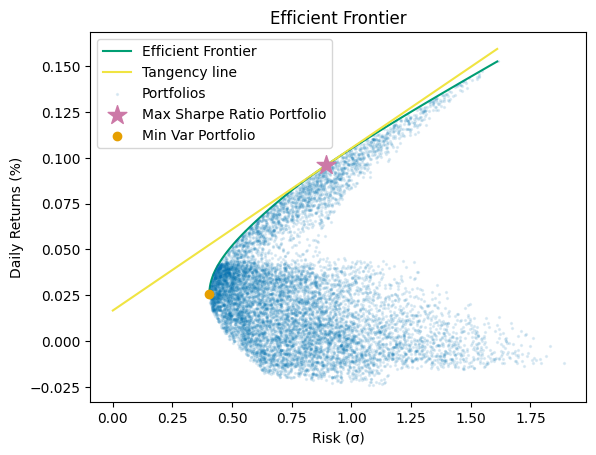

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(
    optimized_risks, target_returns, c="#009E73", zorder=1, label="Efficient Frontier"
)
ax.plot(tangency_xs, tangency_ys, c="#F0E442", zorder=1, label="Tangency line")
ax.scatter(
    simulated_risks,
    simulated_returns,
    alpha=0.1,
    s=2,
    c="#0072B2",
    zorder=10,
    label="Portfolios",
)
ax.scatter(
    [opt_risk],
    [opt_return],
    c="#CC79A7",
    marker="*",
    s=200,
    zorder=10,
    label="Max Sharpe Ratio Portfolio",
)
ax.scatter(
    [min_var_risk], [min_var_return], c="#E69F00", zorder=10, label="Min Var Portfolio"
)
ax.set_xlabel("Risk (σ)")
ax.set_ylabel("Daily Returns (%)")
ax.set_title("Efficient Frontier")
ax.legend()

### Annualize optimum return.

In [26]:
((1 + opt_return / 100) ** 252 - 1) * 100

np.float64(27.367239662705845)